# Predicting Areas of Affluence using Yelp Pricing Data

#### Authors: 
- Eddie Yip
- Hadi Morrow [LinkedIn](https://www.linkedin.com/in/hadi-morrow-4b94164b/) | [GitHub](https://github.com/HadiMorrow) | [Medium](https://medium.com/@hadi.a.morrow)
- Mahdi Shadkam-Farrokhi: [GitHub](https://github.com/Shaddyjr) | [Medium](https://medium.com/@mahdis.pw) | [http://mahdis.pw](http://mahdis.pw)

## Problem Statement [Hadi]

While affluence should never be a factor when choosing to provide disaster aid or not, we must consider the following:

- On the assumption that affluence plays a role, one might relate affluency to preparedness. Those who can afford to will always look out for their families at any cost. Those who can not might not be able to prepare as well due to the fact that it is not an option. 

- On the assumption that affluence is not part of a majority class, if we should be miopic with our search efforts we might want to consider saving the masses, those living in tight coridors and those with little to no income. If effect those most suseptible to losing their lives in a major disaster. 

- Using tax data we aim to show that using YELP data dollar signs is enough to predict where we might want to quickly and accuratly align our efforts. 

New Light Technologies as our audience, we hope to show that while using expensive and hard to handle data such as tax data can be more precise, a quick and dirty aproach could be to simply sord though the dollar signs data on yelp. 

---
[Hadi] - Excellent write up! Here are some of my observations - feel free to include or not, totally up to you.
1. It would be nice for the reader if we define 'affluence' here at the start. What do we consider "affluent" in our data (I think we mentioned 15% of the area code?)?
2. As a reader, it would be VERY compelling to have an actual case where a natural disaster occured and the affluent areas weren't affected. If possible, research 1 or 2 cases when affluent areas were better prepared for natural disasters - this will help prove our predictive model has a real use case.
3. Tying into the use case, it might be helpful to mention a realistic disaster scenario when only having Yelp! price data would be useful. Like, there's an emergency and there's little time to pull granular information about the area, but knowing the yelp reviews for an area, allows first-responders to know which areas their efforts will have the most impact

## Executive Summary [Mahdi]

- Difficulty gathering data
- Prompt confusing regarding "affluence"
- Other projects used outside data as metric
- We pulled from API and didn't use old data, which was challenging

## Table of Contents
- [Gathering Data](#Gathering-Data)
- [Loading Data](#Loading-Data)
- [Preliminary Exploratory Data Analysis](#Preliminary-Exploratory-Data-Analysis)
- [Cleaning the Data](#Cleaning-the-Data)
- [Feature Engineering](#Feature-Engineering)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Model Preparation](#Model-Preparation)
- [Model Selection](#Model-Selection)
- [Model Evaluation](#Model-Evaluation)
- [Conclusions and Recommendations](#Conclusions-and-Recommendations)
- [Source Documentation](#Source-Documentation)

## Gathering Data
We got Yelp data using the API - link 
 
We got IRS data using - source [Eddie]

## Loading Data
- [All]

In [166]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import columnExpander
from ast import literal_eval

In [205]:
data_file_path = "./data/total_merged.csv"
df_yelp = pd.read_csv(data_file_path, index_col = 0)
df_yelp.reset_index(drop=True, inplace = True) # same indeces were merged using multiple API calls

## Preliminary Exploratory Data Analysis
- [All]

In [206]:
df_yelp.head()

,alias,categories,coordinates,display_phone,distance,id,image_url,is_closed,location,name,phone,price,rating,review_count,transactions,url
0,mos-original-brooklyn,"[{'alias': 'ramen', 'title': 'Ramen'}, {'alias...","{'latitude': 40.66127, 'longitude': -73.95342}",(718) 513-0698,1542.617156,YwpP-mgXV5N35xhLibLw5g,https://s3-media2.fl.yelpcdn.com/bphoto/-L9roT...,False,"{'address1': '453 Rogers Ave', 'address2': Non...",Mo's Original,1.718513e+10,NaN,4.5,32,[],https://www.yelp.com/biz/mos-original-brooklyn...
1,peaches-hothouse-brooklyn,"[{'alias': 'southern', 'title': 'Southern'}, {...","{'latitude': 40.6833699737169, 'longitude': -7...",(718) 483-9111,3471.525420,GA5msU6NO9rQRctPfDJCBg,https://s3-media1.fl.yelpcdn.com/bphoto/KEAXgZ...,False,"{'address1': '415 Tompkins Ave', 'address2': '...",Peaches HotHouse,1.718484e+10,$$,4.0,1082,"['pickup', 'delivery']",https://www.yelp.com/biz/peaches-hothouse-broo...
2,claw-daddys-brooklyn,"[{'alias': 'cajun', 'title': 'Cajun/Creole'}, ...","{'latitude': 40.68561, 'longitude': -73.98035}",(347) 318-8893,5062.337404,1x2hn3e9sCCZca1cnRTpEg,https://s3-media3.fl.yelpcdn.com/bphoto/ABHo2x...,False,"{'address1': '31 3rd Ave', 'address2': '', 'ad...",Claw Daddy's,1.347319e+10,$$,4.0,282,['restaurant_reservation'],https://www.yelp.com/biz/claw-daddys-brooklyn?...
3,barons-brooklyn,"[{'alias': 'newamerican', 'title': 'American (...","{'latitude': 40.6908116, 'longitude': -73.953915}",(718) 230-7100,4451.492133,GxMhN2PEttvw7CRGIzB6Gg,https://s3-media3.fl.yelpcdn.com/bphoto/VmnsId...,False,"{'address1': '564 Dekalb Ave', 'address2': '',...",Baron's,1.718231e+10,$$,4.5,258,"['pickup', 'restaurant_reservation']",https://www.yelp.com/biz/barons-brooklyn?adjus...
4,lowerline-brooklyn-2,"[{'alias': 'cajun', 'title': 'Cajun/Creole'}, ...","{'latitude': 40.67421, 'longitude': -73.96324}",(347) 533-7110,3158.955607,swKXaURwqdSrSTcpHsxdbA,https://s3-media4.fl.yelpcdn.com/bphoto/oJbAhL...,False,"{'address1': '794 Washington Ave', 'address2':...",Lowerline,1.347534e+10,$$,4.5,118,[],https://www.yelp.com/biz/lowerline-brooklyn-2?...


In [207]:
df_yelp['latitude'] = [literal_eval(i)['latitude'] for i in df_yelp['coordinates']]
df_yelp['longitude'] = [literal_eval(i)['longitude'] for i in df_yelp['coordinates']]

In [208]:
sum_null = df_yelp.isnull().sum()
sum_null[sum_null > 0]

display_phone     697
image_url         417
phone             697
price            2013
latitude            1
longitude           1
dtype: int64

We have many missing values in the data, however many of the columns are not meaningful for our problem and these columns can be safely dropped.

Also, `categories`, `location`, and `transactions` are compressed data columns and will need to be unpacked.

## Cleaning the Data
- [Mahdi] one person for consistency

### Dropping unneccessary columns

In [209]:
keepers = ['categories','id', 'location', 'price', 'rating', 'review_count', 'transactions', 'latitude', 'longitude']
df_yelp = df_yelp[keepers]

Convert price to binary

In [210]:
df_yelp["price"].isnull().sum()

2013

We decided to drop null prices from analysis and bring back to maybe cluster for analysis later

In [211]:
df_yelp.dropna(subset=["price"], inplace = True)

In [212]:
df_yelp.shape

(9212, 9)

There are no null values - this is a complete dataset

### Parsing location

In [213]:
def get_keys_from_sting_dict(string, keys):
    if len(string) == 0:
        return None
    dic = literal_eval(string)
    out = {}
    for key in keys:
        out[key] = dic.get(key)
    return out

In [214]:
keys = ["zip_code", "city", 'state']
zips_and_cities = df_yelp["location"].map(lambda string: get_keys_from_sting_dict(string, keys))

for key in keys:
    df_yelp[key] = [pair[key] for pair in zips_and_cities]

In [215]:
df_yelp.head()

,categories,id,location,price,rating,review_count,transactions,latitude,longitude,zip_code,city,state
1,"[{'alias': 'southern', 'title': 'Southern'}, {...",GA5msU6NO9rQRctPfDJCBg,"{'address1': '415 Tompkins Ave', 'address2': '...",$$,4.0,1082,"['pickup', 'delivery']",40.683370,-73.943780,11216,Brooklyn,NY
2,"[{'alias': 'cajun', 'title': 'Cajun/Creole'}, ...",1x2hn3e9sCCZca1cnRTpEg,"{'address1': '31 3rd Ave', 'address2': '', 'ad...",$$,4.0,282,['restaurant_reservation'],40.685610,-73.980350,11217,Brooklyn,NY
3,"[{'alias': 'newamerican', 'title': 'American (...",GxMhN2PEttvw7CRGIzB6Gg,"{'address1': '564 Dekalb Ave', 'address2': '',...",$$,4.5,258,"['pickup', 'restaurant_reservation']",40.690812,-73.953915,11205,Brooklyn,NY
4,"[{'alias': 'cajun', 'title': 'Cajun/Creole'}, ...",swKXaURwqdSrSTcpHsxdbA,"{'address1': '794 Washington Ave', 'address2':...",$$,4.5,118,[],40.674210,-73.963240,11238,Brooklyn,NY
5,"[{'alias': 'tradamerican', 'title': 'American ...",CwOAKJdX8AMz5iAoA-ZEuA,"{'address1': '166 Smith St', 'address2': '', '...",$$,4.0,453,"['pickup', 'delivery', 'restaurant_reservation']",40.686023,-73.991302,11201,Brooklyn,NY


### Parsing categories

In [216]:
def convert_string_dict_to_string(string, key):
    return ",".join([dic[key] for dic in literal_eval(string)])

df_yelp["categories"] = df_yelp["categories"].map(lambda s: convert_string_dict_to_string(s,"alias"))

### Parsing transactions

In [217]:
def convert_string_list_to_string(string):
    return ",".join(literal_eval(string))

df_yelp["transactions"] = df_yelp["transactions"].map(convert_string_list_to_string)

In [218]:
df_yelp.shape

(9212, 12)

### Filtering for NYC-only

#### Removed non-NY state

In [219]:
df_yelp = df_yelp[df_yelp['state'] == "NY"]

#### Imputing missing zip codes

In [220]:
df_yelp[df_yelp['zip_code'] == ""]

,categories,id,location,price,rating,review_count,transactions,latitude,longitude,zip_code,city,state
6940,"cupcakes,bakeries,customcakes",ECY0sIYxPJio81dteqiMhg,"{'address1': '', 'address2': None, 'address3':...",$$,4.5,16,,40.714550,-74.007140,,New York,NY
8092,bakeries,6u5cnsN35mJz24HMQ9pfFw,"{'address1': '', 'address2': '', 'address3': '...",$$,2.0,15,,40.605271,-74.149243,,Staten Island,NY
10283,foodstands,BilbRcNQXKmcBFvLm4gxAQ,"{'address1': '74 St 37th Ave', 'address2': '',...",$$,5.0,3,,40.748864,-73.891896,,Queens,NY
10401,"farmersmarket,localflavor",jZzbV6SRt9FXdCoziNv5xw,{'address1': '41st Ave between 80th & 81st St'...,$$,4.0,4,,40.745464,-73.887683,,Queens,NY


Locations were found using Google Maps and zip codes imputed manually

In [221]:
df_yelp[df_yelp["id"] == "ECY0sIYxPJio81dteqiMhg"] = "10007"
df_yelp[df_yelp["id"] == "6u5cnsN35mJz24HMQ9pfFw"] = "10314"
df_yelp[df_yelp["id"] == "BilbRcNQXKmcBFvLm4gxAQ"] = "11372"
df_yelp[df_yelp["id"] == "jZzbV6SRt9FXdCoziNv5xw"] = "11373"

### Remove by NYC zip
We used the range of zip codes designated for NYC - [source](https://www.nycbynatives.com/nyc_info/new_york_city_zip_codes.php)

In [222]:
min_zip = 10001
max_zip = 11697

df_yelp['zip_code'] = df_yelp['zip_code'].astype(int)

In [223]:
df_yelp = df_yelp[(df_yelp['zip_code'] >= min_zip) & (df_yelp['zip_code'] <= max_zip)]

### Cleaning IRS Dataset [Hadi]
These data were collected directly from the IRS website ([source](https://www.irs.gov/statistics/soi-tax-stats-individual-income-tax-statistics-2016-zip-code-data-soi))

Check if all zip codes from yelp dataset exists in irs dataset

In [224]:
df_irs = pd.read_csv('./data/irs.csv')

In [225]:
df_irs[10:20]

,ZIP code [1],Size of adjusted gross income,Number of returns,Number of single returns,Number of joint returns,Number of head of household returns,Number with paid preparer's signature,Number of exemptions,Number of dependents
10,10001,"$25,000 under $50,000",2500,1850,240,340,1360,3390,690
11,10001,"$50,000 under $75,000",1950,1540,190,160,1110,2440,310
12,10001,"$75,000 under $100,000",1410,1120,170,80,820,1760,190
13,10001,"$100,000 under $200,000",2580,1850,560,90,1540,3580,440
14,10001,"$200,000 or more",2340,1200,1030,50,1760,4150,790
15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,10002,NaN,"42,180","25,270","10,500","5,630","28,170","68,970","17,490"
17,10002,"$1 under $25,000",21180,12550,5360,2950,15360,33920,8490
18,10002,"$25,000 under $50,000",8210,4660,1900,1480,5150,14540,4480
19,10002,"$50,000 under $75,000",4810,3300,730,670,2780,7120,1590


In [226]:
yelp_zips = list(set(df_yelp['zip_code']))

In [227]:
def clean_str_num(str_num):
    '''Returns integer of input string with commas removed'''
    return int(str_num.replace(',',''))

In [228]:
affluency_rates = []
found_zips = []
missing_zips = []
returns_col_name = 'Number of returns'

for zip_code in yelp_zips:
    try:
        sub_df               = df_irs[df_irs.iloc[:,0] == str(zip_code)]
        
        affluent_irs_returns = clean_str_num(sub_df[returns_col_name].iloc[-1])
        total_irs_returns    = clean_str_num(sub_df[returns_col_name].iloc[0])
        affluent_rate        = affluent_irs_returns / total_irs_returns
        
        affluency_rates.append(affluent_rate)
        found_zips.append(zip_code)
    except Exception as e:
        missing_zips.append(zip_code)
        pass

In [229]:
len(missing_zips)

26

There are 26 zip codes in the yelp data that were not found in the IRS dataset.  
These associated datapoint will be dropped, as they have not target value.

In [230]:
affluency_df = pd.DataFrame(data = {"zip_code": found_zips, "affluency_rate":affluency_rates})
affluency_df.head()

,zip_code,affluency_rate
0,10801,0.052004
1,10803,0.300000
2,10301,0.047013
3,10302,0.018564
4,10303,0.007395


### Merging Yelp and IRS dataset
Merging the yelp dataset with the IRS dataset will drop those observations with missing zip codes.

In [231]:
df = pd.merge(df_yelp, affluency_df, on = "zip_code")

In [232]:
df.shape

(8871, 13)

### Changing Target to Ordinal Data

Converted all the dollar signs into numerical ranking from 1 to 4

In [233]:
df['price'] = df['price'].map({'$': 1, '$$': 2, '$$$': 3, '$$$$':4})

In [234]:
df['price'].value_counts()

2.0    4893
1.0    3281
3.0     565
4.0     128
Name: price, dtype: int64

### Changing Data Type

In [235]:
df['review_count'] = df['review_count'].astype(int)
df['rating'] = df['rating'].astype(int)

In [236]:
df['latitude'] = df['latitude'].astype(float)
df['longitude'] = df['longitude'].astype(float)

In [237]:
df[df['longitude']  0]

,categories,id,location,price,rating,review_count,transactions,latitude,longitude,zip_code,city,state,affluency_rate
3267,11372,11372,11372,NaN,11372,11372,11372,11372.000000,11372.000000,11372,11372,11372,0.019132
3915,11373,11373,11373,NaN,11373,11373,11373,11373.000000,11373.000000,11373,11373,11373,0.006487
5559,icecream,dF02U8Yhxnm66Np4Adgovg,"{'address1': '132 Spring St', 'address2': None...",2.0,4,290,,40.723884,74.000792,10012,New York,NY,0.203689
6569,10007,10007,10007,NaN,10007,10007,10007,10007.000000,10007.000000,10007,10007,10007,0.456395
7729,pizza,S2mqyVGw817y9GTHxYRPjw,"{'address1': '2170 Cross Bronx Expy', 'address...",1.0,4,58,,40.830034,73.850772,10472,Bronx,NY,0.001731
8569,10314,10314,10314,NaN,10314,10314,10314,10314.000000,10314.000000,10314,10314,10314,0.045164


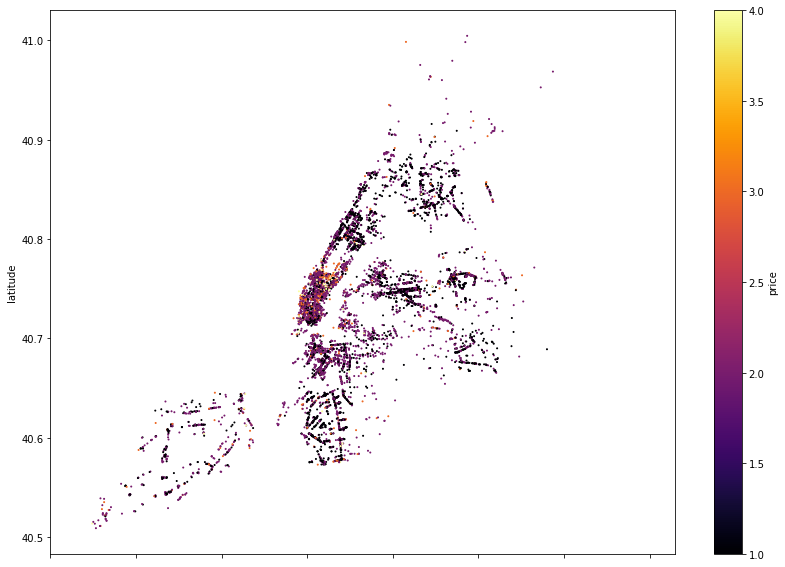

In [248]:
df.plot(kind="scatter", y="latitude", x="longitude", c="price",
         cmap="inferno", figsize=(14, 10), s=1, xlim = (-74.3, -73.57));

We are left with 8871 complete data points

## Feature Engineering
- [All]

### Creating Dummy Variables

In [239]:
expansion_columns = ["categories","transactions"]
lce = columnExpander.ListColumnExpander(expansion_columns)
lce.fit(df)

## Exploratory Data Analysis
- [Mahdi] and [Eddie] killer graphs and visuals

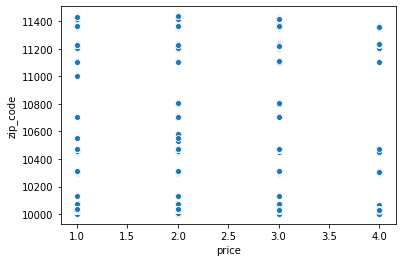

In [240]:
sns.scatterplot(data = df, x = 'price', y = 'zip_code')

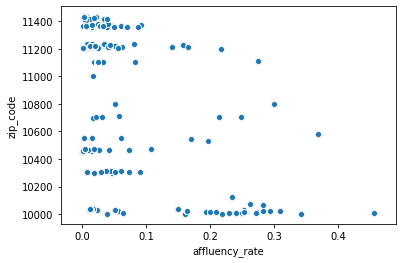

In [51]:
sns.scatterplot(data = df, x = 'affluency_rate', y = 'zip_code')

0       1082
1        303
2        200
3        178
4        140
5        115
6        190
7        682
8        323
9         75
10       107
11       104
12       113
13       278
14       315
15        58
16       287
17       393
18        76
19        82
20       153
21       117
22        52
23       179
24       174
25       196
26        55
27        26
28        70
29        37
        ... 
8841      14
8842     119
8843      69
8844      27
8845      26
8846      10
8847      15
8848      17
8849      24
8850       9
8851       5
8852      10
8853      19
8854      19
8855      15
8856       4
8857      19
8858       3
8859       2
8860       4
8861       1
8862      43
8863      69
8864     142
8865      25
8866      37
8867      13
8868       7
8869       2
8870       1
Name: review_count, Length: 8871, dtype: int32

## Model Preparation

In [47]:
target = 'affluency_rate'
y = df[target]

## Model Selection
- [Hadi] Exploring models
- [Eddie] Exploring models

Maybe split on which models you 2 want to try out

## Model Evaluation
- [Mahdi] killer graphs and visuals

## Conclusions and Recommendations
- [All]

## Source Documentation
- [NYC zip codes](https://www.nycbynatives.com/nyc_info/new_york_city_zip_codes.php)
- [Yelp API - Business Endpoints](https://www.yelp.com/fusion)
- [IRS dataset](https://www.irs.gov/statistics/soi-tax-stats-individual-income-tax-statistics-2016-zip-code-data-soi)